In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LassoCV

# for kaggle

# dataset_path = "/kaggle/input/cicids-17/merged_output.csv"

# data = pd.read_csv(dataset_path)

# for local
data=pd.read_csv('merged_output.csv', encoding='utf-8')
data.columns = data.columns.str.strip()


data = data.replace([np.inf, -np.inf], np.nan).dropna()


y = data['Label']
X = data.drop('Label', axis=1)


le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = y_encoded


constant_features = [col for col in X.columns if X[col].nunique() == 1]
X.drop(columns=constant_features, inplace=True)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=['Label'])
y_test = pd.DataFrame(y_test, columns=['Label'])


ensemble_features = ['Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Max Packet Length', 'Packet Length Std', 'Packet Length Variance', 'Avg Bwd Segment Size', 'Bwd Packet Length Std', 'Flow IAT Max', 'Packet Length Mean', 'Average Packet Size', 'Fwd IAT Std', 'Fwd IAT Max', 'PSH Flag Count', 'Idle Mean', 'Idle Max', 'Idle Min', 'Init_Win_bytes_forward', 'Flow Duration', 'Flow IAT Std', 'Fwd IAT Total']

print(len(X_train.columns))
print(len(X_test.columns))


X_train = X_train[ensemble_features]
X_test = X_test[ensemble_features]

print(len(X_train))
print(len(X_test))

70
70
1886070
471518


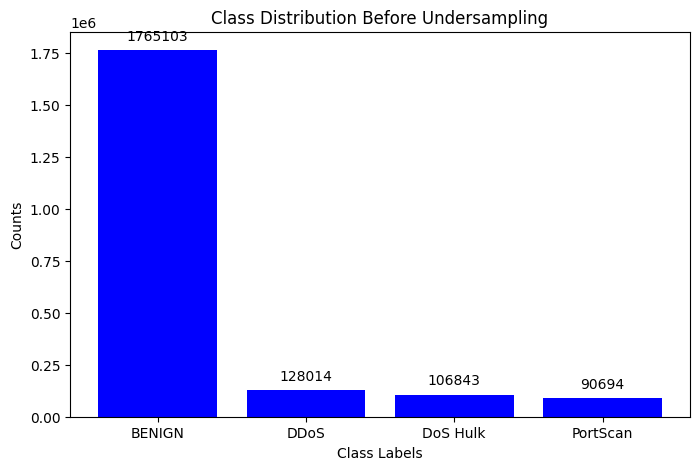

In [11]:
import matplotlib.pyplot as plt



labels_before = ["BENIGN", "DDoS", "DoS Hulk", "PortScan"]
counts_before = [1765103, 128014, 106843, 90694]


labels_after = ["BENIGN", "DDoS", "DoS Hulk", "PortScan"]
counts_after = [150000, 127043, 110748, 102420]


def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  
                    textcoords="offset points",
                    ha='center', va='bottom')


fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(labels_before, counts_before, color='blue')
add_labels(ax, bars)
ax.set_xlabel('Class Labels')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution Before Undersampling')
plt.show()



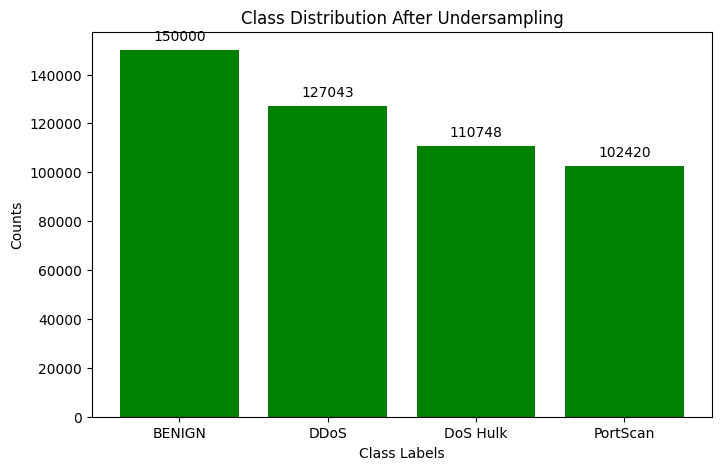

In [12]:

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(labels_after, counts_after, color='green')
add_labels(ax, bars)
ax.set_xlabel('Class Labels')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution After Undersampling')
plt.show()

Under sample the BENIGN to reduce the Bias 

In [10]:
from imblearn.under_sampling import RandomUnderSampler


X_train_np = X_train.values
y_train_np = y_train.values.ravel()


print(np.unique(y_train_np, return_counts=True))


benign_encoded_value = 0  


rus = RandomUnderSampler(sampling_strategy={benign_encoded_value: 150000}, random_state=42)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train_np, y_train_np)


X_train = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train = pd.DataFrame(y_train_resampled, columns=['Label'])


print("Class distribution after undersampling:")
print(pd.Series(y_train_resampled).value_counts())


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([1522420,    1565,  102420,  110748,    4399,    4637,    6348,
            29,  127043,    4717,    1205,      17,     522]))
Class distribution after undersampling:
0     150000
8     127043
3     110748
2     102420
6       6348
9       4717
5       4637
4       4399
1       1565
10      1205
12       522
7         29
11        17
Name: count, dtype: int64


decision tree without handling imbalance

--- Training Evaluation ---
Accuracy: 0.9995
Precision: 0.9995
Recall: 0.9995
F1-score: 0.9995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150000
           1       0.98      0.99      0.99      1565
           2       1.00      1.00      1.00    102420
           3       1.00      1.00      1.00    110748
           4       1.00      1.00      1.00      4399
           5       1.00      1.00      1.00      4637
           6       1.00      1.00      1.00      6348
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00    127043
           9       1.00      1.00      1.00      4717
          10       0.99      1.00      0.99      1205
          11       1.00      0.88      0.94        17
          12       1.00      1.00      1.00       522

    accuracy                           1.00    513650
   macro avg       1.00      0.99      0.99    513650
weighted avg       1.00      1.00      

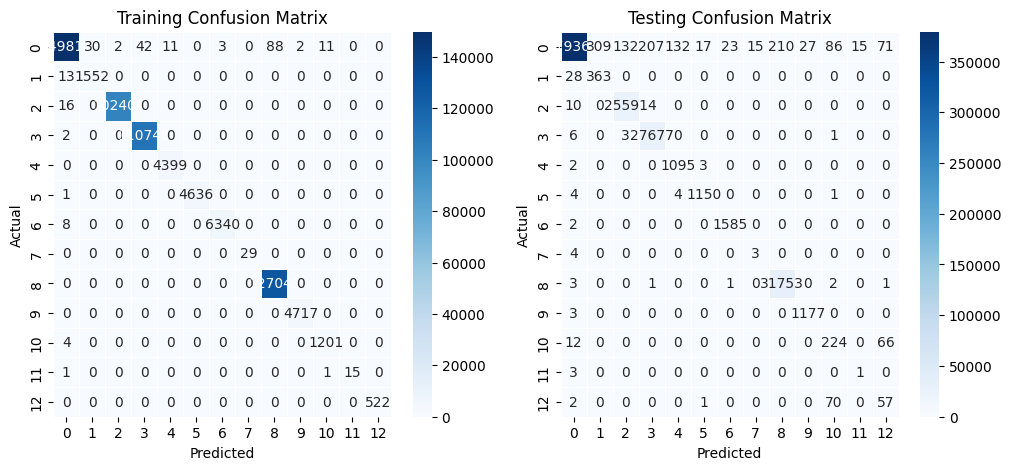

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


dt = DecisionTreeClassifier(random_state=42)


dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)


train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)


train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")


print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


feature_importance = dt.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]



decision tree with imbalance handling

--- Training Evaluation ---
Accuracy: 0.9993
Precision: 0.9994
Recall: 0.9993
F1-score: 0.9994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150000
           1       0.94      1.00      0.97      1565
           2       1.00      1.00      1.00    102420
           3       1.00      1.00      1.00    110748
           4       1.00      1.00      1.00      4399
           5       1.00      1.00      1.00      4637
           6       0.99      1.00      1.00      6348
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00    127043
           9       1.00      1.00      1.00      4717
          10       0.99      0.98      0.99      1205
          11       0.35      1.00      0.52        17
          12       1.00      1.00      1.00       522

    accuracy                           1.00    513650
   macro avg       0.94      1.00      0.96    513650
weighted avg       1.00      1.00      

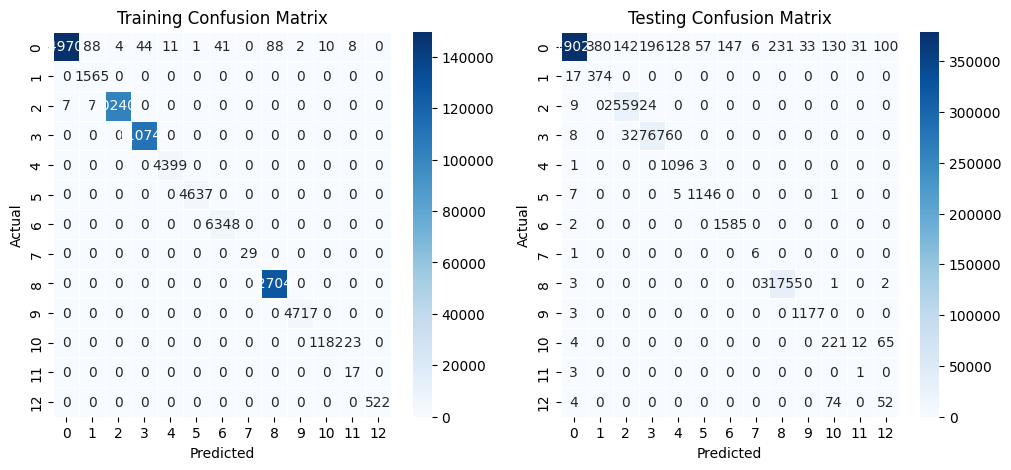

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")


dt.fit(X_train, y_train)


y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)


train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)

train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")


print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


MLP

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- MLP Training Evaluation ---
Accuracy: 0.9727
Precision: 0.9709
Recall: 0.9727
F1-score: 0.9706


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.95      0.96    150000
           1       0.84      0.61      0.71      1565
           2       0.99      1.00      1.00    102420
           3       0.94      0.99      0.97    110748
           4       0.96      0.98      0.97      4399
           5       0.98      0.87      0.92      4637
           6       0.97      0.99      0.98      6348
           7       0.00      0.00      0.00        29
           8       0.98      1.00      0.99    127043
           9       1.00      0.50      0.67      4717
          10       0.32      0.07      0.12      1205
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00       522

    accuracy                           0.97    513650
   macro avg       0.69      0.61      0.64    513650
weighted avg       0.97      0.97      0.97    513650


--- MLP Testing Evaluation ---
Accuracy: 0.9552
Precision: 0.9649
Recall: 0.95

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97    380605
           1       0.35      0.64      0.46       391
           2       0.97      1.00      0.99     25605
           3       0.71      1.00      0.83     27687
           4       0.78      0.98      0.87      1100
           5       0.84      0.85      0.84      1159
           6       0.78      1.00      0.87      1587
           7       0.00      0.00      0.00         7
           8       0.82      1.00      0.90     31761
           9       0.99      0.49      0.65      1180
          10       0.08      0.07      0.07       302
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00       130

    accuracy                           0.96    471518
   macro avg       0.56      0.61      0.57    471518
weighted avg       0.96      0.96      0.96    471518



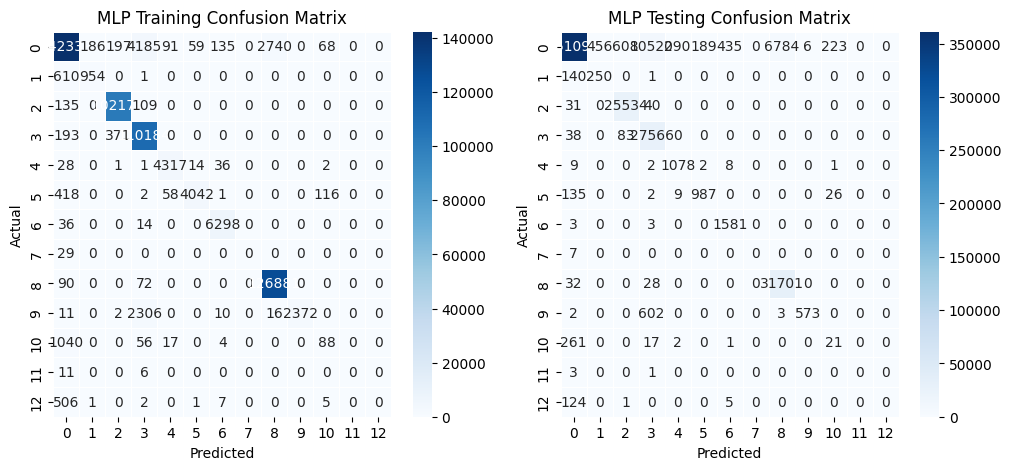

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32, 16, 8, 4, 13), activation='relu', solver='adam', max_iter=300, random_state=42)

mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

train_accuracy = mlp_model.score(X_train, y_train)
test_accuracy = mlp_model.score(X_test, y_test)

train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

print(f"--- MLP Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- MLP Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("MLP Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("MLP Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


xgboost with handling  imbalance

In [13]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:13:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Training Evaluation ---
Accuracy: 0.9960
Precision: 0.9957
Recall: 0.9960
F1-score: 0.9957


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99    150000
           1       0.93      0.95      0.94      1565
           2       1.00      1.00      1.00    102420
           3       1.00      1.00      1.00    110748
           4       0.99      0.99      0.99      4399
           5       1.00      1.00      1.00      4637
           6       1.00      1.00      1.00      6348
           7       1.00      0.14      0.24        29
           8       1.00      1.00      1.00    127043
           9       1.00      0.99      0.99      4717
          10       0.53      0.94      0.68      1205
          11       0.00      0.00      0.00        17
          12       0.00      0.00      0.00       522

    accuracy                           1.00    513650
   macro avg       0.80      0.77      0.76    513650
weighted avg       1.00      1.00      1.00    513650


--- Testing Evaluation ---
Accuracy: 0.9939
Precision: 0.9962
Recall: 0.9939
F

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    380605
           1       0.60      0.95      0.73       391
           2       1.00      1.00      1.00     25605
           3       0.97      1.00      0.99     27687
           4       0.94      0.99      0.96      1100
           5       0.99      0.99      0.99      1159
           6       0.99      1.00      0.99      1587
           7       0.00      0.00      0.00         7
           8       0.99      1.00      1.00     31761
           9       0.97      0.99      0.98      1180
          10       0.17      0.93      0.29       302
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00       130

    accuracy                           0.99    471518
   macro avg       0.66      0.76      0.69    471518
weighted avg       1.00      0.99      0.99    471518



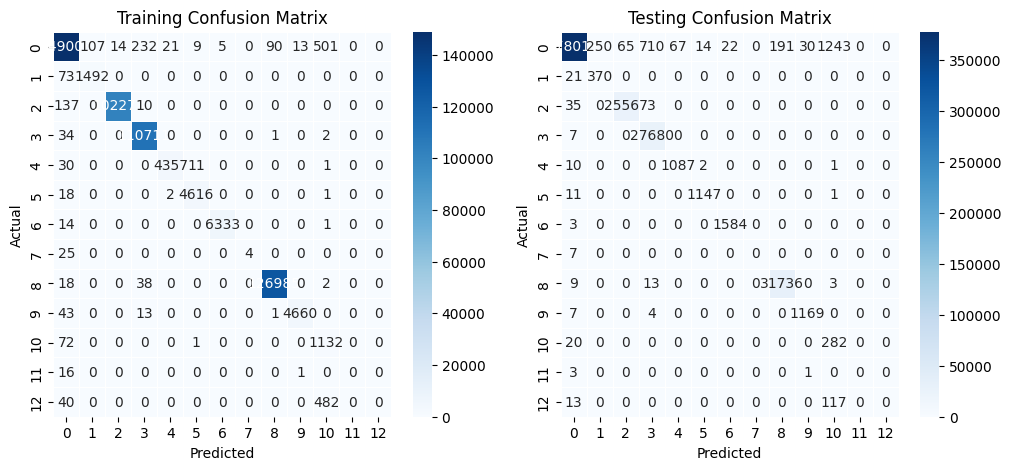

In [14]:
import xgboost as xgb
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


class_counts = Counter(y_train)
max_count = max(class_counts.values())
scale_pos_weights = {cls: max_count / count for cls, count in class_counts.items()}


class_weight_list = np.array([scale_pos_weights[label] for label in sorted(class_counts.keys())])


xg = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    gamma=2,
    tree_method="auto",
    objective="multi:softmax", 
    num_class=len(class_counts), 
    scale_pos_weight=class_weight_list, 
    eval_metric="mlogloss",
    random_state=42
)


xg.fit(X_train, y_train)


y_train_pred = xg.predict(X_train)
y_test_pred = xg.predict(X_test)


train_accuracy = xg.score(X_train, y_train)
test_accuracy = xg.score(X_test, y_test)


train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")


print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()

xgboost without imbalance handling

--- Training Evaluation ---
Accuracy: 0.9972
Precision: 0.9978
Recall: 0.9972
F1-score: 0.9970
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150000
           1       0.93      0.95      0.94      1565
           2       1.00      1.00      1.00    102420
           3       1.00      1.00      1.00    110748
           4       1.00      0.99      1.00      4399
           5       1.00      1.00      1.00      4637
           6       1.00      1.00      1.00      6348
           7       1.00      0.76      0.86        29
           8       1.00      1.00      1.00    127043
           9       1.00      1.00      1.00      4717
          10       0.58      0.97      0.73      1205
          11       1.00      0.53      0.69        17
          12       0.87      0.07      0.12       522

    accuracy                           1.00    513650
   macro avg       0.95      0.87      0.87    513650
weighted avg       1.00      1.00      

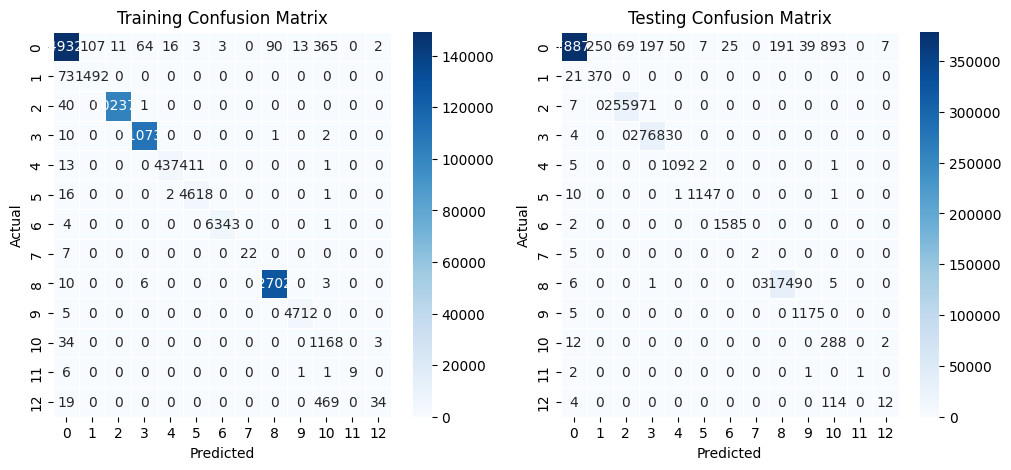

In [15]:

import xgboost as xgb
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


xg = xgb.XGBClassifier( n_estimators=50,max_depth=6, learning_rate=0.2,
    tree_method="auto",
    random_state=42
)


xg.fit(X_train, y_train)


y_train_pred = xg.predict(X_train)
y_test_pred = xg.predict(X_test)


train_accuracy = xg.score(X_train, y_train)
test_accuracy = xg.score(X_test, y_test)


train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")


print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()



random forest with imbalance handling


--- Training Evaluation ---
Accuracy: 0.9863
Precision: 0.9975
Recall: 0.9863
F1-score: 0.9914
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    150000
           1       0.40      1.00      0.58      1565
           2       1.00      1.00      1.00    102420
           3       1.00      1.00      1.00    110748
           4       1.00      1.00      1.00      4399
           5       1.00      1.00      1.00      4637
           6       1.00      1.00      1.00      6348
           7       1.00      1.00      1.00        29
           8       1.00      1.00      1.00    127043
           9       1.00      1.00      1.00      4717
          10       1.00      0.95      0.97      1205
          11       0.00      1.00      0.01        17
          12       1.00      0.98      0.99       522

    accuracy                           0.99    513650
   macro avg       0.88      0.99      0.89    513650
weighted avg       1.00      0.99      

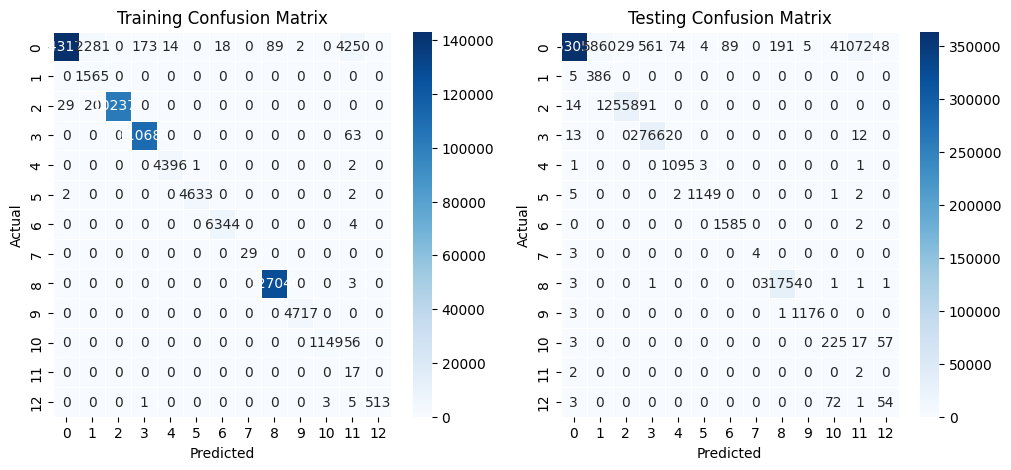

In [18]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_train = np.array(y_train).ravel()


classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}


rf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight=class_weight_dict)


rf.fit(X_train, y_train)


y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)


train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")


print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


random forest without imbalance handling

Random Forest without imbalance handling


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Training Evaluation ---
Accuracy: 0.9945
Precision: 0.9946
Recall: 0.9945
F1-score: 0.9938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150000
           1       0.98      0.95      0.97      1565
           2       1.00      1.00      1.00    102420
           3       0.98      1.00      0.99    110748
           4       1.00      1.00      1.00      4399
           5       1.00      1.00      1.00      4637
           6       1.00      1.00      1.00      6348
           7       1.00      0.97      0.98        29
           8       1.00      1.00      1.00    127043
           9       1.00      0.52      0.68      4717
          10       1.00      0.92      0.95      1205
          11       1.00      0.65      0.79        17
          12       1.00      0.98      0.99       522

    accuracy                           0.99    513650
   macro avg       1.00      0.92      0.95    513650
weighted avg       0.99      0.99      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380605
           1       0.61      0.93      0.74       391
           2       1.00      1.00      1.00     25605
           3       0.96      1.00      0.98     27687
           4       0.94      1.00      0.96      1100
           5       0.99      0.99      0.99      1159
           6       0.99      1.00      0.99      1587
           7       0.43      0.43      0.43         7
           8       0.99      1.00      1.00     31761
           9       0.99      0.50      0.66      1180
          10       0.72      0.70      0.71       302
          11       0.00      0.00      0.00         4
          12       0.42      0.39      0.41       130

    accuracy                           1.00    471518
   macro avg       0.77      0.76      0.76    471518
weighted avg       1.00      1.00      1.00    471518



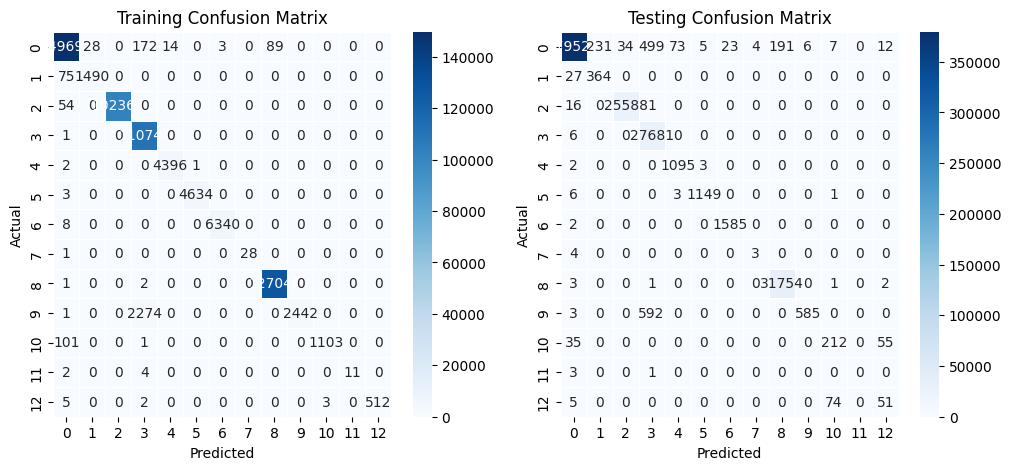

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


rf = RandomForestClassifier(n_estimators=50, random_state=42)


rf.fit(X_train, y_train)


y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)


train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)


train_precision, train_recall, train_fscore, _ = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
test_precision, test_recall, test_fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")


print(f"--- Training Evaluation ---")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_fscore:.4f}")
print(classification_report(y_train, y_train_pred))

print(f"\n--- Testing Evaluation ---")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_fscore:.4f}")
print(classification_report(y_test, y_test_pred))


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, linewidths=0.5, fmt=".0f", cmap="Blues", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()
